In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="1"

In [2]:
# Importing packages
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import albumentations as A
from albumentations.pytorch import ToTensorV2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import os
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
import torchmetrics
import torchinfo
from torchinfo import summary
import torch.nn.functional as F
from torch.nn import CrossEntropyLoss
import cv2

from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [4]:
from typing import Protocol, runtime_checkable

@runtime_checkable
class Closable(Protocol):
    def close(self):
        ...

class AnyClass:
    def close(self):
        ...

issubclass(AnyClass, Closable)
#> True

True

In [5]:
>>> from typing_extensions import Protocol
>>> from typing_extensions import runtime_checkable

>>> @runtime_checkable
... class CustomProtocol(Protocol):
...     def custom(self):
...         ...
... 

>>> @runtime_checkable
... class ExtendedCustomProtocol(CustomProtocol, Protocol):
...     def extended(self):
...         ...
... 

>>> issubclass(ExtendedCustomProtocol, CustomProtocol)
True

True

In [6]:
# Data pathes
train_images = 'D:/Dataset (Plant)/Identifying Disease in Tea leaves/train'
val_images = 'D:/Dataset (Plant)/Identifying Disease in Tea leaves/test'

In [7]:
# Hyperparams
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(DEVICE)
IN_CHANNELS = 3
CLASSES = 3
TRAIN_BATCH = 16
VALID_BATCH = 16
NUM_WORKERS = 0
LR = 0.001
EPOCHS = 100

cuda:0


In [8]:
# Train and test augmentations
class Transforms:
    def __init__(self, transforms: A.Compose):
        self.transforms = transforms

    def __call__(self, img, *args, **kwargs):
        return self.transforms(image=np.array(img))['image']

A_train = A.Compose([A.SmallestMaxSize(max_size=256), 
                     A.RandomCrop(height=224, width=224, always_apply=True),
                     A.OneOf([
                       A.VerticalFlip(p=1),
                       A.HorizontalFlip(p=1),
                       A.RandomRotate90(p=1)], p=1),  
                     A.Normalize(
                                mean=[0.4299, 0.4328, 0.3964], 
                                std=[0.2711, 0.2666, 0.2816],
                                max_pixel_value=255.0),
                  ToTensorV2()])

A_val =  A.Compose([ A.SmallestMaxSize(256),
                    A.RandomCrop(height=224, width=224, always_apply=True),
                   A.Normalize(
                                mean=[0.4299, 0.4328, 0.3964], 
                                std=[0.2711, 0.2666, 0.2816],
                                max_pixel_value=255.0),
                   ToTensorV2()])

In [9]:
class MassachussetsDataset(Dataset):
    def __init__(self, img_path, mask_path, transforms=None):
        super().__init__()
        self.img_path = img_path
        self.mask_path = mask_path
        self.transforms = transforms
        self.images_list = os.listdir(img_path)

    def __len__(self):
        return len(self.images_list)

    def __getitem__(self, index):
        image = np.array(Image.open(os.path.join(self.img_path, self.images_list[index])).convert("RGB"))
        mask = np.array(Image.open(os.path.join(self.mask_path, self.images_list[index].replace('.jpg', '_mask.gif'))).convert("L"), dtype=np.float32)
        mask[mask==255] = 1.0

        if self.transforms is not None:
            aug  = self.transforms(image=image, mask=mask)
            image = aug['image']
            mask = aug['mask']
            

        return image, mask

In [10]:
# Datasets and Dataloaders
train_set = torchvision.datasets.ImageFolder(train_images, transform=Transforms(transforms=A_train))
valid_set = torchvision.datasets.ImageFolder(val_images, Transforms(transforms=A_val))

train_loader = DataLoader(train_set, shuffle=True, batch_size=TRAIN_BATCH, num_workers=NUM_WORKERS)
valid_loader = DataLoader(valid_set, shuffle=True, batch_size=VALID_BATCH, num_workers=NUM_WORKERS)

In [11]:
next(iter(valid_loader))[0].size()

torch.Size([16, 3, 224, 224])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


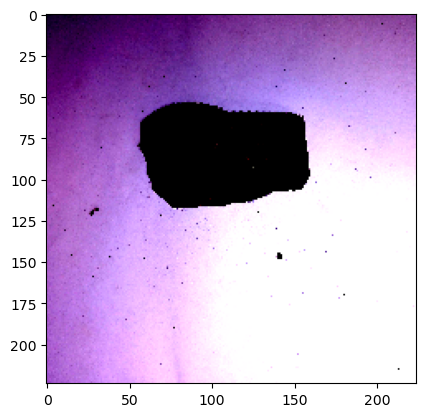

In [12]:
img, mask = train_set[10]
plt.imshow(img.permute(1, 2, 0))

In [14]:
for i, (im, mas) in enumerate(valid_loader):
    print(im.size(), mas.size())
    break

torch.Size([16, 3, 224, 224]) torch.Size([16])


In [15]:
def double_conv(in_c, out_c):
    conv = nn.Sequential(
        nn.Conv2d(in_c, out_c, kernel_size=3, padding=1),
        nn.ReLU(inplace=True),
        nn.Conv2d(out_c, out_c, kernel_size=3, padding=1),
        nn.ReLU(inplace=True),
    )
    return conv

def crop_img(tensor, target_tensor):
    target_size = target_tensor.size()[2]
    tensor_size = tensor.size()[2]
    delta = tensor_size - target_size
    delta = delta // 2
    return tensor[:, :, delta:tensor_size-delta, delta:tensor_size-delta]




class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()
        
        self.max_pool_2x2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.down_conv_1 = double_conv(3, 64)
        self.down_conv_2 = double_conv(64+32, 128)
        self.down_conv_3 = double_conv(128+32, 256)
        self.down_conv_4 = double_conv(256+32, 512)
        self.down_conv_5 = double_conv(512+32, 1024)
        
        self.up_trans_1 = nn.ConvTranspose2d(
            in_channels=1024,
            out_channels=512,
            kernel_size=2,
            stride=2)
        self.up_conv_1 = double_conv(1024, 512)     
        self.up_conv_1_a = double_conv(1024-256, 512)
        
        self.up_trans_2 = nn.ConvTranspose2d(
            in_channels=512,
            out_channels=256,
            kernel_size=2,
            stride=2)
        self.up_conv_2 = double_conv(512, 256)
        self.up_conv_2_a = double_conv(512-128, 256)


        self.up_trans_3 = nn.ConvTranspose2d(
            in_channels=256,
            out_channels=128,
            kernel_size=2,
            stride=2)
        self.up_conv_3 = double_conv(256, 128)
        self.up_conv_3_a = double_conv(256-64, 128)

        self.up_trans_4 = nn.ConvTranspose2d(
            in_channels=128,
            out_channels=64,
            kernel_size=2,
            stride=2)
        self.up_conv_4 = double_conv(128, 64) 
        
        self.out = nn.Conv2d(
           in_channels=64,
           out_channels=1,
           kernel_size=1
        )
        self.classification = nn.Linear(224*224,15)
        
        #Image resizer
        self.resize_conv1 = nn.Sequential(nn.Upsample(scale_factor=1/2), nn.Conv2d(3,32,kernel_size=3, padding=1))
        self.resize_conv2 = nn.Sequential(nn.Upsample(scale_factor=1/4), nn.Conv2d(3,32,kernel_size=3, padding=1))
        self.resize_conv3 = nn.Sequential(nn.Upsample(scale_factor=1/8), nn.Conv2d(3,32,kernel_size=3, padding=1))
        self.resize_conv4 = nn.Sequential(nn.Upsample(scale_factor=1/16), nn.Conv2d(3,32,kernel_size=3, padding=1))
        
        
        
    def forward(self, image):
        # bs, c, h, w
        # encoder
        x1 = self.down_conv_1(image)
        x2 = self.max_pool_2x2(x1)
        
        rx1 = self.resize_conv1(image)
        x2 = torch.cat((x2, rx1), dim=1)
        x3 = self.down_conv_2(x2)
        x4 = self.max_pool_2x2(x3)
        
        rx2 = self.resize_conv2(image)
        x4 = torch.cat((x4, rx2), dim=1)
        x5 = self.down_conv_3(x4)
        x6 = self.max_pool_2x2(x5)
        
        rx3 = self.resize_conv3(image)
        x6 = torch.cat((x6, rx3), dim=1)
        x7 = self.down_conv_4(x6)
        x8 = self.max_pool_2x2(x7)
        
        rx4 = self.resize_conv4(image)
        x8 = torch.cat((x8, rx4), dim=1)
        x9 = self.down_conv_5(x8)
        
        
        # decoder
        
        # decoder 1
        x = self.up_trans_1(x9) 
        y = crop_img(x7, x)
        x = self.up_conv_1(torch.cat([x, y], 1))
        sss = crop_img(x5, x)
        x = self.up_conv_1_a(torch.cat([x, sss], 1))

        
        # decoder 2
        x = self.up_trans_2(x)
        y = crop_img(x5, x)
        x = self.up_conv_2(torch.cat([x, y], 1))   
        sss = crop_img(x3, x)
        x = self.up_conv_2_a(torch.cat([x, sss], 1))
        
        x_a = self.up_trans_2(x7)
        y = crop_img(x_a, x)
        x = self.up_conv_2(torch.cat([x_a, y], 1))   
        
        # decoder 3
        x = self.up_trans_3(x)
        y = crop_img(x3, x)
        x = self.up_conv_3(torch.cat([x, y], 1))
        
        sss = crop_img(x1, x)
        x = self.up_conv_3_a(torch.cat([x, sss], 1))
        
        x_a = self.up_trans_3(x5)
        y = crop_img(x_a, x)
        x = self.up_conv_3(torch.cat([x_a, y], 1)) 
        
        # decoder 4
        x = self.up_trans_4(x)
        y = crop_img(x1, x)
        x = self.up_conv_4(torch.cat([x, y], 1))
        
        x_a = self.up_trans_4(x3)
        y = crop_img(x_a, x)
        x = self.up_conv_4(torch.cat([x_a, y], 1)) 
        
        x = self.out(x)
        x = x.reshape(image.size(0), -1)
        x = self.classification(x)
        return x
        
        
if __name__ == "__main__":
    image = torch.rand((2,3,224,224))
    model = UNet()
    print(model(image).size())        


torch.Size([2, 15])


In [16]:
model = UNet().to(DEVICE)
model = model.to(DEVICE)

In [17]:
model.load_state_dict(torch.load("C:/Users/Owner/Training/Unet/saved models/Identifying Disease in Tea leaves(multi_input_cross_layer.pt"))

model.eval()
valid_losses = []
valid_iou = []
correct, total=0.0,0.0
preds=torch.zeros(160,1)
labels=torch.zeros(160,1)
l=0
with torch.no_grad():
    loop2 = tqdm(valid_loader)
    for i, (im, mas) in enumerate(loop2):
        images = im.to(DEVICE)
        masks = mas.to(DEVICE)

        outputs = model(images)
        probab=torch.argmax(outputs,axis=1)
        print(torch.argmax(outputs,axis=1).size())
       
        for j in range(int(torch.argmax(outputs,axis=1).size(dim=0))):
            preds[l,0]=probab[j]
            labels[l,0]=masks[j]
            l+=1

        _, predicted = torch.max(outputs.data, 1)
        total += masks.size(0)
        correct += (predicted == masks).sum().item()
print(correct/160)


import torchmetrics
precision = torchmetrics.classification.MulticlassPrecision(8)
print("Precision: ", precision(preds,labels))

Recall = torchmetrics.classification.MulticlassRecall(8)
print("Recall: ", Recall(preds,labels))

f1=torchmetrics.classification.MulticlassF1Score(8)
print("F1 Score: ", f1(preds,labels))

  0%|                                                                                           | 0/10 [00:00<?, ?it/s]

torch.Size([16])


 20%|████████████████▌                                                                  | 2/10 [00:04<00:16,  2.09s/it]

torch.Size([16])


 30%|████████████████████████▉                                                          | 3/10 [00:05<00:11,  1.57s/it]

torch.Size([16])


 40%|█████████████████████████████████▏                                                 | 4/10 [00:06<00:07,  1.18s/it]

torch.Size([16])


 50%|█████████████████████████████████████████▌                                         | 5/10 [00:07<00:06,  1.21s/it]

torch.Size([16])


 60%|█████████████████████████████████████████████████▊                                 | 6/10 [00:08<00:04,  1.14s/it]

torch.Size([16])


 70%|██████████████████████████████████████████████████████████                         | 7/10 [00:09<00:03,  1.15s/it]

torch.Size([16])


 80%|██████████████████████████████████████████████████████████████████▍                | 8/10 [00:10<00:02,  1.13s/it]

torch.Size([16])


 90%|██████████████████████████████████████████████████████████████████████████▋        | 9/10 [00:11<00:01,  1.14s/it]

torch.Size([16])


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:12<00:00,  1.23s/it]

torch.Size([16])
0.9
Precision:  tensor(0.9029)
Recall:  tensor(0.9000)
F1 Score:  tensor(0.8994)


In [17]:
torchinfo.summary(model, input_size=(8, 3, 224,224))

Layer (type:depth-idx)                   Output Shape              Param #
UNet                                     [8, 15]                   --
├─Sequential: 1-1                        [8, 64, 224, 224]         --
│    └─Conv2d: 2-1                       [8, 64, 224, 224]         1,792
│    └─ReLU: 2-2                         [8, 64, 224, 224]         --
│    └─Conv2d: 2-3                       [8, 64, 224, 224]         36,928
│    └─ReLU: 2-4                         [8, 64, 224, 224]         --
├─MaxPool2d: 1-2                         [8, 64, 112, 112]         --
├─Sequential: 1-3                        [8, 32, 112, 112]         --
│    └─Upsample: 2-5                     [8, 3, 112, 112]          --
│    └─Conv2d: 2-6                       [8, 32, 112, 112]         896
├─Sequential: 1-4                        [8, 128, 112, 112]        --
│    └─Conv2d: 2-7                       [8, 128, 112, 112]        110,720
│    └─ReLU: 2-8                         [8, 128, 112, 112]        --
│ 

In [18]:
# Custom loss functions
class DiceLoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceLoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):
        
        #comment out if your model contains a sigmoid or equivalent activation layer
        inputs = F.sigmoid(inputs)       
        
        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        intersection = (inputs * targets).sum()                            
        dice = (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)  
        
        return 1 - dice
    
#####################################################################################    
class DiceBCELoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceBCELoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):
        
        #comment out if your model contains a sigmoid or equivalent activation layer
        inputs = F.sigmoid(inputs)       
        
        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        intersection = (inputs * targets).sum()                            
        dice_loss = 1 - (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)  
        BCE = F.binary_cross_entropy(inputs, targets, reduction='mean')
        Dice_BCE = BCE + dice_loss
        
        return Dice_BCE
#####################################################################################    
class IoULoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(IoULoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):
        
        #comment out if your model contains a sigmoid or equivalent activation layer
        inputs = F.sigmoid(inputs)       
        
        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        #intersection is equivalent to True Positive count
        #union is the mutually inclusive area of all labels & predictions 
        intersection = (inputs * targets).sum()
        total = (inputs + targets).sum()
        union = total - intersection 
        
        IoU = (intersection + smooth)/(union + smooth)
                
        return 1 - IoU
    
#####################################################################################    
ALPHA = 0.8
GAMMA = 2

class FocalLoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(FocalLoss, self).__init__()

    def forward(self, inputs, targets, alpha=0.8, gamma=2, smooth=1):
        
        #comment out if your model contains a sigmoid or equivalent activation layer
        inputs = F.sigmoid(inputs)       
        
        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        #first compute binary cross-entropy 
        BCE = F.binary_cross_entropy(inputs, targets, reduction='mean')
        BCE_EXP = torch.exp(-BCE)
        focal_loss = alpha * (1-BCE_EXP)**gamma * BCE
                       
        return focal_loss
    
    
#####################################################################################
ALPHA = 0.5
BETA = 0.5

class TverskyLoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(TverskyLoss, self).__init__()

    def forward(self, inputs, targets, smooth=1, alpha=ALPHA, beta=BETA):
        
        #comment out if your model contains a sigmoid or equivalent activation layer
        inputs = F.sigmoid(inputs)       
        
        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        #True Positives, False Positives & False Negatives
        TP = (inputs * targets).sum()    
        FP = ((1-targets) * inputs).sum()
        FN = (targets * (1-inputs)).sum()
       
        Tversky = (TP + smooth) / (TP + alpha*FP + beta*FN + smooth)  
        
        return 1 - Tversky

In [19]:
criterion = CrossEntropyLoss().to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=LR)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)

In [20]:
def mIoU(pred_mask, mask, smooth=1e-10, n_classes=CLASSES):
    with torch.no_grad():
        pred_mask = nn.functional.sigmoid(pred_mask)
        pred_mask = (pred_mask > 0.5).float()
        pred_mask = pred_mask.contiguous().view(-1)
        mask = mask.contiguous().view(-1)

        iou_per_class = []
        for clas in range(0, n_classes): #loop per pixel class
            true_class = pred_mask == clas
            true_label = mask == clas

            if true_label.long().sum().item() == 0: #no exist label in this loop
                iou_per_class.append(np.nan)
            else:
                intersect = torch.logical_and(true_class, true_label).sum().float().item()
                union = torch.logical_or(true_class, true_label).sum().float().item()

                iou = (intersect + smooth) / (union + smooth)
                iou_per_class.append(iou)
        return np.nanmean(iou_per_class)

In [21]:
def plot_images(img, mask, pred):
    f, ax = plt.subplots(1, 3)
    ax[0].imshow(img)
    ax[0].set_xlabel("Image")
    ax[1].imshow(mask)
    ax[1].set_xlabel("Ground Truth")
    ax[2].imshow(pred)
    ax[2].set_xlabel("Prediction")

In [22]:
train_loss_values = []
valid_loss_values = []
train_iou_values = []
valid_iou_values = []

for epoch in range(200):
    loop = tqdm(train_loader)
    train_losses = []
    train_iou = []
    # training_loop
    model.train()
    for batch_id, (images, masks) in enumerate(loop):

        images = images.to(DEVICE)
        masks = masks.to(DEVICE)
        
        outputs = model(images)

        loss = criterion(outputs, masks)
        train_losses.append(loss.item())
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    #Validation loop    
    model.eval()
    valid_losses = []
    valid_iou = []
    correct, total=0.0,0.0

    with torch.no_grad():
        loop2 = tqdm(valid_loader)
        for i, (im, mas) in enumerate(loop2):
            images = im.to(DEVICE)
            masks = mas.to(DEVICE)

            outputs = model(images)
            
            _, predicted = torch.max(outputs.data, 1)
            total += masks.size(0)
            correct += (predicted == masks).sum().item()
            
            val_loss = criterion(outputs, masks)
            valid_losses.append(val_loss.item())
        
    scheduler.step()
        
    train_loss_values.append(np.mean(train_losses))
    valid_loss_values.append(np.mean(valid_losses))
    
    if (epoch+1) % 10 == 0:
        torch.save(model.state_dict(), "C:/Users/Owner/Training/Unet/saved models/Identifying Disease in Tea leaves(multi_input_cross_layer.pt")
        
    print(f"Epoch-{epoch+1} Train mean loss: {np.mean(train_losses):.4f}")
    print(f"Epoch-{epoch+1} Valid mean loss: {np.mean(valid_losses):.4f} Valid Accuracy: {correct/total:.4f}")

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:11<00:00,  1.19s/it]


Epoch-1 Train mean loss: 2.8482
Epoch-1 Valid mean loss: 2.1103 Valid Accuracy: 0.1187


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:12<00:00,  1.20s/it]


Epoch-2 Train mean loss: 1.7687
Epoch-2 Valid mean loss: 1.3418 Valid Accuracy: 0.3812


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:12<00:00,  1.22s/it]


Epoch-3 Train mean loss: 1.3203
Epoch-3 Valid mean loss: 1.0681 Valid Accuracy: 0.4813


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:12<00:00,  1.21s/it]


Epoch-4 Train mean loss: 1.2122
Epoch-4 Valid mean loss: 1.0562 Valid Accuracy: 0.5437


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:12<00:00,  1.21s/it]


Epoch-5 Train mean loss: 1.1075
Epoch-5 Valid mean loss: 1.3828 Valid Accuracy: 0.5312


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:12<00:00,  1.21s/it]


Epoch-6 Train mean loss: 1.0912
Epoch-6 Valid mean loss: 1.0383 Valid Accuracy: 0.5125


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:12<00:00,  1.22s/it]


Epoch-7 Train mean loss: 1.0036
Epoch-7 Valid mean loss: 0.9861 Valid Accuracy: 0.5312


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:12<00:00,  1.21s/it]


Epoch-8 Train mean loss: 1.0412
Epoch-8 Valid mean loss: 0.9517 Valid Accuracy: 0.5750


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:12<00:00,  1.23s/it]


Epoch-9 Train mean loss: 0.9188
Epoch-9 Valid mean loss: 0.8444 Valid Accuracy: 0.5625


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:12<00:00,  1.22s/it]


Epoch-10 Train mean loss: 0.9843
Epoch-10 Valid mean loss: 0.8439 Valid Accuracy: 0.5625


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:11<00:00,  1.19s/it]


Epoch-11 Train mean loss: 0.9276
Epoch-11 Valid mean loss: 1.3610 Valid Accuracy: 0.5687


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:11<00:00,  1.18s/it]


Epoch-12 Train mean loss: 0.9984
Epoch-12 Valid mean loss: 1.0670 Valid Accuracy: 0.5437


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:11<00:00,  1.20s/it]


Epoch-13 Train mean loss: 0.8616
Epoch-13 Valid mean loss: 0.9496 Valid Accuracy: 0.5000


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:12<00:00,  1.21s/it]


Epoch-14 Train mean loss: 0.8802
Epoch-14 Valid mean loss: 0.9812 Valid Accuracy: 0.6312


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:11<00:00,  1.20s/it]


Epoch-15 Train mean loss: 0.8193
Epoch-15 Valid mean loss: 0.8125 Valid Accuracy: 0.5938


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:11<00:00,  1.19s/it]


Epoch-16 Train mean loss: 0.7509
Epoch-16 Valid mean loss: 0.7075 Valid Accuracy: 0.6500


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:12<00:00,  1.20s/it]


Epoch-17 Train mean loss: 0.7569
Epoch-17 Valid mean loss: 0.9259 Valid Accuracy: 0.5938


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:12<00:00,  1.22s/it]


Epoch-18 Train mean loss: 0.9612
Epoch-18 Valid mean loss: 0.7559 Valid Accuracy: 0.6500


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:12<00:00,  1.21s/it]


Epoch-19 Train mean loss: 0.7757
Epoch-19 Valid mean loss: 0.7570 Valid Accuracy: 0.6562


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:12<00:00,  1.22s/it]


Epoch-20 Train mean loss: 0.6702
Epoch-20 Valid mean loss: 0.6646 Valid Accuracy: 0.6875


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:12<00:00,  1.21s/it]


Epoch-21 Train mean loss: 0.7657
Epoch-21 Valid mean loss: 0.9561 Valid Accuracy: 0.5500


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:12<00:00,  1.23s/it]


Epoch-22 Train mean loss: 0.6628
Epoch-22 Valid mean loss: 0.8391 Valid Accuracy: 0.6500


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:12<00:00,  1.23s/it]


Epoch-23 Train mean loss: 0.7793
Epoch-23 Valid mean loss: 0.8277 Valid Accuracy: 0.6000


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:12<00:00,  1.22s/it]


Epoch-24 Train mean loss: 0.7541
Epoch-24 Valid mean loss: 0.7084 Valid Accuracy: 0.6375


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:12<00:00,  1.22s/it]


Epoch-25 Train mean loss: 0.7164
Epoch-25 Valid mean loss: 0.7482 Valid Accuracy: 0.6125


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:12<00:00,  1.22s/it]


Epoch-26 Train mean loss: 0.6550
Epoch-26 Valid mean loss: 0.6865 Valid Accuracy: 0.6750


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:12<00:00,  1.23s/it]


Epoch-27 Train mean loss: 0.5724
Epoch-27 Valid mean loss: 0.6473 Valid Accuracy: 0.6937


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:12<00:00,  1.20s/it]


Epoch-28 Train mean loss: 0.6381
Epoch-28 Valid mean loss: 0.6089 Valid Accuracy: 0.7312


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:12<00:00,  1.22s/it]


Epoch-29 Train mean loss: 0.6683
Epoch-29 Valid mean loss: 0.7113 Valid Accuracy: 0.6438


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:12<00:00,  1.22s/it]


Epoch-30 Train mean loss: 0.6358
Epoch-30 Valid mean loss: 0.7269 Valid Accuracy: 0.6687


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:12<00:00,  1.24s/it]


Epoch-31 Train mean loss: 0.6412
Epoch-31 Valid mean loss: 0.7711 Valid Accuracy: 0.6750


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:12<00:00,  1.21s/it]


Epoch-32 Train mean loss: 0.5552
Epoch-32 Valid mean loss: 0.5318 Valid Accuracy: 0.7625


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:12<00:00,  1.20s/it]


Epoch-33 Train mean loss: 0.5108
Epoch-33 Valid mean loss: 0.5671 Valid Accuracy: 0.7625


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:12<00:00,  1.20s/it]


Epoch-34 Train mean loss: 0.7186
Epoch-34 Valid mean loss: 0.7350 Valid Accuracy: 0.6875


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:12<00:00,  1.21s/it]


Epoch-35 Train mean loss: 0.5536
Epoch-35 Valid mean loss: 0.6438 Valid Accuracy: 0.7063


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:12<00:00,  1.20s/it]


Epoch-36 Train mean loss: 0.5592
Epoch-36 Valid mean loss: 0.5940 Valid Accuracy: 0.7375


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:12<00:00,  1.25s/it]


Epoch-37 Train mean loss: 0.5722
Epoch-37 Valid mean loss: 0.6156 Valid Accuracy: 0.7000


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:12<00:00,  1.21s/it]


Epoch-38 Train mean loss: 1.0548
Epoch-38 Valid mean loss: 1.0644 Valid Accuracy: 0.5813


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:12<00:00,  1.22s/it]


Epoch-39 Train mean loss: 1.6228
Epoch-39 Valid mean loss: 0.6660 Valid Accuracy: 0.6937


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:11<00:00,  1.20s/it]


Epoch-40 Train mean loss: 0.6368
Epoch-40 Valid mean loss: 0.6391 Valid Accuracy: 0.6687


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:12<00:00,  1.25s/it]


Epoch-41 Train mean loss: 0.5868
Epoch-41 Valid mean loss: 0.5668 Valid Accuracy: 0.7625


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:12<00:00,  1.22s/it]


Epoch-42 Train mean loss: 0.5367
Epoch-42 Valid mean loss: 0.6281 Valid Accuracy: 0.7125


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:11<00:00,  1.20s/it]


Epoch-43 Train mean loss: 0.5722
Epoch-43 Valid mean loss: 0.6213 Valid Accuracy: 0.7312


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:12<00:00,  1.25s/it]


Epoch-44 Train mean loss: 0.5134
Epoch-44 Valid mean loss: 0.6043 Valid Accuracy: 0.7438


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:12<00:00,  1.23s/it]


Epoch-45 Train mean loss: 0.5010
Epoch-45 Valid mean loss: 0.8303 Valid Accuracy: 0.7000


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:12<00:00,  1.21s/it]


Epoch-46 Train mean loss: 0.4563
Epoch-46 Valid mean loss: 0.5286 Valid Accuracy: 0.7562


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:12<00:00,  1.22s/it]


Epoch-47 Train mean loss: 0.4785
Epoch-47 Valid mean loss: 0.6121 Valid Accuracy: 0.7000


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:12<00:00,  1.21s/it]


Epoch-48 Train mean loss: 0.4651
Epoch-48 Valid mean loss: 0.5721 Valid Accuracy: 0.7312


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:12<00:00,  1.21s/it]


Epoch-49 Train mean loss: 0.4528
Epoch-49 Valid mean loss: 0.7805 Valid Accuracy: 0.6937


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:12<00:00,  1.24s/it]


Epoch-50 Train mean loss: 0.5205
Epoch-50 Valid mean loss: 0.7316 Valid Accuracy: 0.6875


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:12<00:00,  1.24s/it]


Epoch-51 Train mean loss: 0.6126
Epoch-51 Valid mean loss: 0.6992 Valid Accuracy: 0.6687


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:12<00:00,  1.21s/it]


Epoch-52 Train mean loss: 0.4287
Epoch-52 Valid mean loss: 0.5926 Valid Accuracy: 0.7000


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:12<00:00,  1.22s/it]


Epoch-53 Train mean loss: 0.4484
Epoch-53 Valid mean loss: 0.7727 Valid Accuracy: 0.7125


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:12<00:00,  1.21s/it]


Epoch-54 Train mean loss: 0.4602
Epoch-54 Valid mean loss: 0.6138 Valid Accuracy: 0.7438


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:12<00:00,  1.22s/it]


Epoch-55 Train mean loss: 0.4340
Epoch-55 Valid mean loss: 0.6139 Valid Accuracy: 0.7688


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:12<00:00,  1.23s/it]


Epoch-56 Train mean loss: 0.3941
Epoch-56 Valid mean loss: 0.4787 Valid Accuracy: 0.7937


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:12<00:00,  1.22s/it]


Epoch-57 Train mean loss: 0.4021
Epoch-57 Valid mean loss: 0.5429 Valid Accuracy: 0.7688


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:11<00:00,  1.20s/it]


Epoch-58 Train mean loss: 0.5786
Epoch-58 Valid mean loss: 0.7601 Valid Accuracy: 0.6875


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:12<00:00,  1.22s/it]


Epoch-59 Train mean loss: 0.4635
Epoch-59 Valid mean loss: 0.7536 Valid Accuracy: 0.6937


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:12<00:00,  1.21s/it]


Epoch-60 Train mean loss: 0.4410
Epoch-60 Valid mean loss: 0.5748 Valid Accuracy: 0.7562


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:12<00:00,  1.22s/it]


Epoch-61 Train mean loss: 0.4389
Epoch-61 Valid mean loss: 0.6558 Valid Accuracy: 0.7375


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:12<00:00,  1.24s/it]


Epoch-62 Train mean loss: 0.4048
Epoch-62 Valid mean loss: 0.4529 Valid Accuracy: 0.7750


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:12<00:00,  1.22s/it]


Epoch-63 Train mean loss: 0.4019
Epoch-63 Valid mean loss: 0.5524 Valid Accuracy: 0.7812


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:12<00:00,  1.21s/it]


Epoch-64 Train mean loss: 0.3388
Epoch-64 Valid mean loss: 0.4499 Valid Accuracy: 0.8250


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:12<00:00,  1.21s/it]


Epoch-65 Train mean loss: 0.3191
Epoch-65 Valid mean loss: 0.6530 Valid Accuracy: 0.7625


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:11<00:00,  1.20s/it]


Epoch-66 Train mean loss: 0.3441
Epoch-66 Valid mean loss: 0.5686 Valid Accuracy: 0.7812


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:12<00:00,  1.21s/it]


Epoch-67 Train mean loss: 0.3300
Epoch-67 Valid mean loss: 0.4802 Valid Accuracy: 0.8375


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:11<00:00,  1.19s/it]


Epoch-68 Train mean loss: 0.4001
Epoch-68 Valid mean loss: 0.5781 Valid Accuracy: 0.7500


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:11<00:00,  1.20s/it]


Epoch-69 Train mean loss: 0.3791
Epoch-69 Valid mean loss: 0.6961 Valid Accuracy: 0.7562


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:11<00:00,  1.19s/it]


Epoch-70 Train mean loss: 0.3785
Epoch-70 Valid mean loss: 0.4681 Valid Accuracy: 0.7688


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:11<00:00,  1.19s/it]


Epoch-71 Train mean loss: 0.3607
Epoch-71 Valid mean loss: 0.6445 Valid Accuracy: 0.7250


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:11<00:00,  1.20s/it]


Epoch-72 Train mean loss: 0.3566
Epoch-72 Valid mean loss: 0.4777 Valid Accuracy: 0.8125


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:12<00:00,  1.22s/it]


Epoch-73 Train mean loss: 0.3609
Epoch-73 Valid mean loss: 0.4271 Valid Accuracy: 0.8000


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:12<00:00,  1.23s/it]


Epoch-74 Train mean loss: 0.3633
Epoch-74 Valid mean loss: 0.5034 Valid Accuracy: 0.8125


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:12<00:00,  1.21s/it]


Epoch-75 Train mean loss: 0.3733
Epoch-75 Valid mean loss: 0.5866 Valid Accuracy: 0.7688


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:12<00:00,  1.21s/it]


Epoch-76 Train mean loss: 0.3361
Epoch-76 Valid mean loss: 0.6008 Valid Accuracy: 0.7750


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:12<00:00,  1.22s/it]


Epoch-77 Train mean loss: 0.3782
Epoch-77 Valid mean loss: 0.4391 Valid Accuracy: 0.7937


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:11<00:00,  1.19s/it]


Epoch-78 Train mean loss: 0.3326
Epoch-78 Valid mean loss: 0.4322 Valid Accuracy: 0.8250


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:12<00:00,  1.23s/it]


Epoch-79 Train mean loss: 0.3136
Epoch-79 Valid mean loss: 0.6544 Valid Accuracy: 0.7500


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:12<00:00,  1.25s/it]


Epoch-80 Train mean loss: 0.3787
Epoch-80 Valid mean loss: 0.5352 Valid Accuracy: 0.7750


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:12<00:00,  1.20s/it]


Epoch-81 Train mean loss: 0.3201
Epoch-81 Valid mean loss: 0.4507 Valid Accuracy: 0.7875


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:12<00:00,  1.22s/it]


Epoch-82 Train mean loss: 0.3211
Epoch-82 Valid mean loss: 0.5427 Valid Accuracy: 0.7750


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:12<00:00,  1.22s/it]


Epoch-83 Train mean loss: 0.3434
Epoch-83 Valid mean loss: 0.4748 Valid Accuracy: 0.8125


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:12<00:00,  1.24s/it]


Epoch-84 Train mean loss: 0.3822
Epoch-84 Valid mean loss: 0.5042 Valid Accuracy: 0.8438


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:12<00:00,  1.23s/it]


Epoch-85 Train mean loss: 0.3107
Epoch-85 Valid mean loss: 0.4892 Valid Accuracy: 0.7812


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:12<00:00,  1.22s/it]


Epoch-86 Train mean loss: 0.3624
Epoch-86 Valid mean loss: 0.5287 Valid Accuracy: 0.7688


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:12<00:00,  1.25s/it]


Epoch-87 Train mean loss: 0.3160
Epoch-87 Valid mean loss: 0.4870 Valid Accuracy: 0.8375


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:12<00:00,  1.20s/it]


Epoch-88 Train mean loss: 0.3213
Epoch-88 Valid mean loss: 0.4168 Valid Accuracy: 0.8187


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:12<00:00,  1.22s/it]


Epoch-89 Train mean loss: 0.2811
Epoch-89 Valid mean loss: 0.7575 Valid Accuracy: 0.7812


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:12<00:00,  1.22s/it]


Epoch-90 Train mean loss: 0.2728
Epoch-90 Valid mean loss: 0.4601 Valid Accuracy: 0.8250


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:11<00:00,  1.20s/it]


Epoch-91 Train mean loss: 0.2668
Epoch-91 Valid mean loss: 0.4782 Valid Accuracy: 0.7688


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:12<00:00,  1.23s/it]


Epoch-92 Train mean loss: 0.2670
Epoch-92 Valid mean loss: 0.5902 Valid Accuracy: 0.7812


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:11<00:00,  1.20s/it]


Epoch-93 Train mean loss: 0.2861
Epoch-93 Valid mean loss: 0.4416 Valid Accuracy: 0.8438


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:12<00:00,  1.22s/it]


Epoch-94 Train mean loss: 0.2664
Epoch-94 Valid mean loss: 0.4892 Valid Accuracy: 0.8187


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:12<00:00,  1.23s/it]


Epoch-95 Train mean loss: 0.2746
Epoch-95 Valid mean loss: 0.4551 Valid Accuracy: 0.8187


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:12<00:00,  1.23s/it]


Epoch-96 Train mean loss: 0.2810
Epoch-96 Valid mean loss: 0.4352 Valid Accuracy: 0.8500


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:12<00:00,  1.22s/it]


Epoch-97 Train mean loss: 0.2646
Epoch-97 Valid mean loss: 0.5727 Valid Accuracy: 0.7937


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:11<00:00,  1.20s/it]


Epoch-98 Train mean loss: 0.2660
Epoch-98 Valid mean loss: 0.4404 Valid Accuracy: 0.8375


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:12<00:00,  1.26s/it]


Epoch-99 Train mean loss: 0.2427
Epoch-99 Valid mean loss: 0.4816 Valid Accuracy: 0.8063


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:12<00:00,  1.23s/it]


Epoch-100 Train mean loss: 0.3095
Epoch-100 Valid mean loss: 0.5005 Valid Accuracy: 0.7812


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:12<00:00,  1.22s/it]


Epoch-101 Train mean loss: 0.2500
Epoch-101 Valid mean loss: 0.3535 Valid Accuracy: 0.8562


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:12<00:00,  1.23s/it]


Epoch-102 Train mean loss: 0.2599
Epoch-102 Valid mean loss: 0.5585 Valid Accuracy: 0.8125


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:12<00:00,  1.22s/it]


Epoch-103 Train mean loss: 0.2445
Epoch-103 Valid mean loss: 0.9185 Valid Accuracy: 0.7625


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:12<00:00,  1.26s/it]


Epoch-104 Train mean loss: 0.4981
Epoch-104 Valid mean loss: 0.3815 Valid Accuracy: 0.8562


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:12<00:00,  1.24s/it]


Epoch-105 Train mean loss: 0.2712
Epoch-105 Valid mean loss: 0.4076 Valid Accuracy: 0.8375


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:12<00:00,  1.24s/it]


Epoch-106 Train mean loss: 0.2293
Epoch-106 Valid mean loss: 0.4404 Valid Accuracy: 0.8125


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:12<00:00,  1.26s/it]


Epoch-107 Train mean loss: 0.2124
Epoch-107 Valid mean loss: 0.4715 Valid Accuracy: 0.8250


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:12<00:00,  1.26s/it]


Epoch-108 Train mean loss: 0.2137
Epoch-108 Valid mean loss: 0.4860 Valid Accuracy: 0.8125


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:12<00:00,  1.28s/it]


Epoch-109 Train mean loss: 0.2128
Epoch-109 Valid mean loss: 0.3634 Valid Accuracy: 0.8750


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:12<00:00,  1.22s/it]


Epoch-110 Train mean loss: 0.1949
Epoch-110 Valid mean loss: 0.5496 Valid Accuracy: 0.8063


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:12<00:00,  1.22s/it]


Epoch-111 Train mean loss: 0.2062
Epoch-111 Valid mean loss: 0.4575 Valid Accuracy: 0.8187


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:12<00:00,  1.21s/it]


Epoch-112 Train mean loss: 0.2040
Epoch-112 Valid mean loss: 0.3932 Valid Accuracy: 0.8562


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:12<00:00,  1.21s/it]


Epoch-113 Train mean loss: 0.2613
Epoch-113 Valid mean loss: 0.3845 Valid Accuracy: 0.8500


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:12<00:00,  1.21s/it]


Epoch-114 Train mean loss: 0.2210
Epoch-114 Valid mean loss: 0.3150 Valid Accuracy: 0.8875


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:12<00:00,  1.21s/it]


Epoch-115 Train mean loss: 0.1877
Epoch-115 Valid mean loss: 0.3846 Valid Accuracy: 0.8750


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:12<00:00,  1.21s/it]


Epoch-116 Train mean loss: 0.2179
Epoch-116 Valid mean loss: 0.3809 Valid Accuracy: 0.8250


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:12<00:00,  1.25s/it]


Epoch-117 Train mean loss: 0.1845
Epoch-117 Valid mean loss: 0.4502 Valid Accuracy: 0.8375


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:12<00:00,  1.27s/it]


Epoch-118 Train mean loss: 0.1908
Epoch-118 Valid mean loss: 0.4017 Valid Accuracy: 0.8938


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:12<00:00,  1.24s/it]


Epoch-119 Train mean loss: 0.1724
Epoch-119 Valid mean loss: 0.4348 Valid Accuracy: 0.8562


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:12<00:00,  1.22s/it]


Epoch-120 Train mean loss: 0.2471
Epoch-120 Valid mean loss: 0.4034 Valid Accuracy: 0.8313


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:12<00:00,  1.21s/it]


Epoch-121 Train mean loss: 0.2363
Epoch-121 Valid mean loss: 0.3737 Valid Accuracy: 0.8562


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:12<00:00,  1.21s/it]


Epoch-122 Train mean loss: 0.1834
Epoch-122 Valid mean loss: 0.4106 Valid Accuracy: 0.8375


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:12<00:00,  1.21s/it]


Epoch-123 Train mean loss: 0.1812
Epoch-123 Valid mean loss: 0.4608 Valid Accuracy: 0.8375


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:12<00:00,  1.23s/it]


Epoch-124 Train mean loss: 0.1632
Epoch-124 Valid mean loss: 0.4182 Valid Accuracy: 0.8562


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:12<00:00,  1.23s/it]


Epoch-125 Train mean loss: 0.1496
Epoch-125 Valid mean loss: 0.3878 Valid Accuracy: 0.8938


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:12<00:00,  1.20s/it]


Epoch-126 Train mean loss: 0.1820
Epoch-126 Valid mean loss: 0.5768 Valid Accuracy: 0.7937


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:12<00:00,  1.20s/it]


Epoch-127 Train mean loss: 0.1818
Epoch-127 Valid mean loss: 0.4552 Valid Accuracy: 0.8125


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:12<00:00,  1.21s/it]


Epoch-128 Train mean loss: 0.1572
Epoch-128 Valid mean loss: 0.3546 Valid Accuracy: 0.8562


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:12<00:00,  1.23s/it]


Epoch-129 Train mean loss: 0.1657
Epoch-129 Valid mean loss: 0.5091 Valid Accuracy: 0.8562


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:12<00:00,  1.22s/it]


Epoch-130 Train mean loss: 0.1426
Epoch-130 Valid mean loss: 0.4203 Valid Accuracy: 0.8375


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:11<00:00,  1.19s/it]


Epoch-131 Train mean loss: 0.1542
Epoch-131 Valid mean loss: 0.4343 Valid Accuracy: 0.8875


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:12<00:00,  1.24s/it]


Epoch-132 Train mean loss: 0.1363
Epoch-132 Valid mean loss: 0.4130 Valid Accuracy: 0.8875


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:11<00:00,  1.19s/it]


Epoch-133 Train mean loss: 0.1369
Epoch-133 Valid mean loss: 0.5402 Valid Accuracy: 0.8250


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:12<00:00,  1.21s/it]


Epoch-134 Train mean loss: 0.1694
Epoch-134 Valid mean loss: 0.4199 Valid Accuracy: 0.8438


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:11<00:00,  1.20s/it]


Epoch-135 Train mean loss: 0.1492
Epoch-135 Valid mean loss: 0.4568 Valid Accuracy: 0.8812


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:12<00:00,  1.21s/it]


Epoch-136 Train mean loss: 0.1783
Epoch-136 Valid mean loss: 0.5753 Valid Accuracy: 0.8313


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:12<00:00,  1.22s/it]


Epoch-137 Train mean loss: 0.1251
Epoch-137 Valid mean loss: 0.6116 Valid Accuracy: 0.8750


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:12<00:00,  1.21s/it]


Epoch-138 Train mean loss: 0.1018
Epoch-138 Valid mean loss: 0.3134 Valid Accuracy: 0.8688


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:12<00:00,  1.21s/it]


Epoch-139 Train mean loss: 0.1359
Epoch-139 Valid mean loss: 0.3008 Valid Accuracy: 0.8938


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:12<00:00,  1.20s/it]


Epoch-140 Train mean loss: 0.1234
Epoch-140 Valid mean loss: 0.5003 Valid Accuracy: 0.8375


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:11<00:00,  1.19s/it]


Epoch-141 Train mean loss: 0.1120
Epoch-141 Valid mean loss: 0.5659 Valid Accuracy: 0.8187


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:12<00:00,  1.24s/it]


Epoch-142 Train mean loss: 0.1339
Epoch-142 Valid mean loss: 0.4181 Valid Accuracy: 0.8500


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:12<00:00,  1.20s/it]


Epoch-143 Train mean loss: 0.1219
Epoch-143 Valid mean loss: 0.4404 Valid Accuracy: 0.8625


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:12<00:00,  1.21s/it]


Epoch-144 Train mean loss: 0.1069
Epoch-144 Valid mean loss: 0.3567 Valid Accuracy: 0.9062


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:12<00:00,  1.21s/it]


Epoch-145 Train mean loss: 0.0982
Epoch-145 Valid mean loss: 0.4451 Valid Accuracy: 0.8313


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:12<00:00,  1.21s/it]


Epoch-146 Train mean loss: 0.1233
Epoch-146 Valid mean loss: 0.4227 Valid Accuracy: 0.8750


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:11<00:00,  1.19s/it]


Epoch-147 Train mean loss: 0.1172
Epoch-147 Valid mean loss: 0.4319 Valid Accuracy: 0.8750


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:11<00:00,  1.19s/it]


Epoch-148 Train mean loss: 0.1256
Epoch-148 Valid mean loss: 0.4181 Valid Accuracy: 0.9000


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:11<00:00,  1.19s/it]


Epoch-149 Train mean loss: 0.0969
Epoch-149 Valid mean loss: 0.4118 Valid Accuracy: 0.8812


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:12<00:00,  1.21s/it]


Epoch-150 Train mean loss: 0.1011
Epoch-150 Valid mean loss: 0.4983 Valid Accuracy: 0.8562


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:11<00:00,  1.20s/it]


Epoch-151 Train mean loss: 0.0884
Epoch-151 Valid mean loss: 0.3718 Valid Accuracy: 0.8875


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:11<00:00,  1.20s/it]


Epoch-152 Train mean loss: 0.0998
Epoch-152 Valid mean loss: 0.3557 Valid Accuracy: 0.8688


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:12<00:00,  1.20s/it]


Epoch-153 Train mean loss: 0.1005
Epoch-153 Valid mean loss: 0.4153 Valid Accuracy: 0.8812


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:11<00:00,  1.18s/it]


Epoch-154 Train mean loss: 0.1040
Epoch-154 Valid mean loss: 0.4641 Valid Accuracy: 0.8562


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:11<00:00,  1.19s/it]


Epoch-155 Train mean loss: 0.0843
Epoch-155 Valid mean loss: 0.3730 Valid Accuracy: 0.8875


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:12<00:00,  1.21s/it]


Epoch-156 Train mean loss: 0.1074
Epoch-156 Valid mean loss: 0.4228 Valid Accuracy: 0.8688


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:12<00:00,  1.23s/it]


Epoch-157 Train mean loss: 0.0905
Epoch-157 Valid mean loss: 0.5108 Valid Accuracy: 0.8688


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:12<00:00,  1.21s/it]


Epoch-158 Train mean loss: 0.0901
Epoch-158 Valid mean loss: 0.4455 Valid Accuracy: 0.8750


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:12<00:00,  1.20s/it]


Epoch-159 Train mean loss: 0.1080
Epoch-159 Valid mean loss: 0.4165 Valid Accuracy: 0.8625


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:12<00:00,  1.22s/it]


Epoch-160 Train mean loss: 0.0786
Epoch-160 Valid mean loss: 0.4064 Valid Accuracy: 0.8938


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:11<00:00,  1.20s/it]


Epoch-161 Train mean loss: 0.0711
Epoch-161 Valid mean loss: 0.3984 Valid Accuracy: 0.8938


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:11<00:00,  1.19s/it]


Epoch-162 Train mean loss: 0.0734
Epoch-162 Valid mean loss: 0.4118 Valid Accuracy: 0.8875


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:12<00:00,  1.20s/it]


Epoch-163 Train mean loss: 0.0857
Epoch-163 Valid mean loss: 0.3197 Valid Accuracy: 0.9062


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:12<00:00,  1.23s/it]


Epoch-164 Train mean loss: 0.0890
Epoch-164 Valid mean loss: 0.4357 Valid Accuracy: 0.8562


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:11<00:00,  1.18s/it]


Epoch-165 Train mean loss: 0.0979
Epoch-165 Valid mean loss: 0.4754 Valid Accuracy: 0.8938


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:11<00:00,  1.20s/it]


Epoch-166 Train mean loss: 0.0674
Epoch-166 Valid mean loss: 0.3428 Valid Accuracy: 0.9062


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:12<00:00,  1.20s/it]


Epoch-167 Train mean loss: 0.0811
Epoch-167 Valid mean loss: 0.4584 Valid Accuracy: 0.8875


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:12<00:00,  1.23s/it]


Epoch-168 Train mean loss: 0.0701
Epoch-168 Valid mean loss: 0.4518 Valid Accuracy: 0.8812


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:11<00:00,  1.20s/it]


Epoch-169 Train mean loss: 0.0679
Epoch-169 Valid mean loss: 0.3367 Valid Accuracy: 0.8938


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:12<00:00,  1.23s/it]


Epoch-170 Train mean loss: 0.0777
Epoch-170 Valid mean loss: 0.4213 Valid Accuracy: 0.8875


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:12<00:00,  1.20s/it]


Epoch-171 Train mean loss: 0.0693
Epoch-171 Valid mean loss: 0.3928 Valid Accuracy: 0.8812


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:11<00:00,  1.19s/it]


Epoch-172 Train mean loss: 0.0595
Epoch-172 Valid mean loss: 0.2594 Valid Accuracy: 0.9125


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:11<00:00,  1.20s/it]


Epoch-173 Train mean loss: 0.0637
Epoch-173 Valid mean loss: 0.3626 Valid Accuracy: 0.8938


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:12<00:00,  1.21s/it]


Epoch-174 Train mean loss: 0.0609
Epoch-174 Valid mean loss: 0.3026 Valid Accuracy: 0.9062


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:12<00:00,  1.21s/it]


Epoch-175 Train mean loss: 0.0642
Epoch-175 Valid mean loss: 0.5408 Valid Accuracy: 0.8688


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:12<00:00,  1.21s/it]


Epoch-176 Train mean loss: 0.0641
Epoch-176 Valid mean loss: 0.4674 Valid Accuracy: 0.9000


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:12<00:00,  1.20s/it]


Epoch-177 Train mean loss: 0.0599
Epoch-177 Valid mean loss: 0.3704 Valid Accuracy: 0.9062


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:11<00:00,  1.20s/it]


Epoch-178 Train mean loss: 0.0576
Epoch-178 Valid mean loss: 0.4576 Valid Accuracy: 0.8750


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:12<00:00,  1.21s/it]


Epoch-179 Train mean loss: 0.0639
Epoch-179 Valid mean loss: 0.4369 Valid Accuracy: 0.8812


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:12<00:00,  1.21s/it]


Epoch-180 Train mean loss: 0.0725
Epoch-180 Valid mean loss: 0.3504 Valid Accuracy: 0.8875


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:11<00:00,  1.17s/it]


Epoch-181 Train mean loss: 0.0714
Epoch-181 Valid mean loss: 0.4239 Valid Accuracy: 0.8875


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:12<00:00,  1.20s/it]


Epoch-182 Train mean loss: 0.0657
Epoch-182 Valid mean loss: 0.3110 Valid Accuracy: 0.8938


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:12<00:00,  1.21s/it]


Epoch-183 Train mean loss: 0.0608
Epoch-183 Valid mean loss: 0.4360 Valid Accuracy: 0.8500


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:12<00:00,  1.22s/it]


Epoch-184 Train mean loss: 0.0592
Epoch-184 Valid mean loss: 0.4172 Valid Accuracy: 0.8938


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:11<00:00,  1.19s/it]


Epoch-185 Train mean loss: 0.0515
Epoch-185 Valid mean loss: 0.2823 Valid Accuracy: 0.9250


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:11<00:00,  1.19s/it]


Epoch-186 Train mean loss: 0.0491
Epoch-186 Valid mean loss: 0.3504 Valid Accuracy: 0.9187


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:12<00:00,  1.20s/it]


Epoch-187 Train mean loss: 0.0522
Epoch-187 Valid mean loss: 0.2997 Valid Accuracy: 0.8875


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:12<00:00,  1.21s/it]


Epoch-188 Train mean loss: 0.0421
Epoch-188 Valid mean loss: 0.5670 Valid Accuracy: 0.8625


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:12<00:00,  1.23s/it]


Epoch-189 Train mean loss: 0.0519
Epoch-189 Valid mean loss: 0.3658 Valid Accuracy: 0.8938


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:11<00:00,  1.18s/it]


Epoch-190 Train mean loss: 0.0546
Epoch-190 Valid mean loss: 0.4706 Valid Accuracy: 0.9000


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:12<00:00,  1.20s/it]


Epoch-191 Train mean loss: 0.0635
Epoch-191 Valid mean loss: 0.4447 Valid Accuracy: 0.8688


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:12<00:00,  1.21s/it]


Epoch-192 Train mean loss: 0.0547
Epoch-192 Valid mean loss: 0.4843 Valid Accuracy: 0.8938


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:11<00:00,  1.20s/it]


Epoch-193 Train mean loss: 0.0491
Epoch-193 Valid mean loss: 0.4201 Valid Accuracy: 0.9000


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:11<00:00,  1.19s/it]


Epoch-194 Train mean loss: 0.0453
Epoch-194 Valid mean loss: 0.4284 Valid Accuracy: 0.8812


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:12<00:00,  1.20s/it]


Epoch-195 Train mean loss: 0.0532
Epoch-195 Valid mean loss: 0.3262 Valid Accuracy: 0.8812


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:12<00:00,  1.20s/it]


Epoch-196 Train mean loss: 0.0543
Epoch-196 Valid mean loss: 0.4167 Valid Accuracy: 0.8938


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:12<00:00,  1.21s/it]


Epoch-197 Train mean loss: 0.0517
Epoch-197 Valid mean loss: 0.4981 Valid Accuracy: 0.8875


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:12<00:00,  1.20s/it]


Epoch-198 Train mean loss: 0.0734
Epoch-198 Valid mean loss: 0.4243 Valid Accuracy: 0.9125


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:12<00:00,  1.21s/it]


Epoch-199 Train mean loss: 0.0417
Epoch-199 Valid mean loss: 0.3890 Valid Accuracy: 0.9000


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:11<00:00,  1.11s/it]

Epoch-200 Train mean loss: 0.0618
Epoch-200 Valid mean loss: 0.4338 Valid Accuracy: 0.9000
